In [1]:
CONFIDENCE = 0.95
ALPHA = 1-CONFIDENCE
LOAD_MODEL_PATH = 'models/AGC_model02_LAC.pth'

In [2]:
#
import os, sys
sys.path.append(os.path.abspath('src/'))
working_dir = os.getcwd()
data_dir = working_dir + '/data/AE_maxillofacial/preprocessed/'

#
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
device = 'cuda'

# Operaciones aleatorias
import random

# Manipulación de datos
import numpy as np
import pandas as pd

# Manejo y edición de imágenes
from PIL import Image

# Evaluación y partición de modelos
from sklearn.model_selection import train_test_split

# Modelos, funciones de pérdida y métricas personalizados 
from conformal_classification_models import *
from cp_metrics import *


In [3]:
# Determina la semilla
SEED = 22

# Fija la semilla para las operaciones aleatorias en Python puro
random.seed(SEED)

# Fija la semilla para las operaciones aleatorias en NumPy
np.random.seed(SEED)

# Fija la semilla para los generadores aleatorios de PyTorch en CPU
torch.manual_seed(SEED)

# Fija la semilla para todos los dispositivos GPU (todas las CUDA devices)
torch.cuda.manual_seed_all(SEED)

# Desactiva la autooptimización de algoritmos en cudnn, que puede introducir no determinismo
# torch.backends.cudnn.benchmark = False

# Fuerza a cudnn a usar operaciones determinísticas (más lento pero reproducible)
# torch.backends.cudnn.deterministic = True

# Obliga a Pytorch a usar algoritmos determinísticos cuando hay alternativa. Si no la hay, lanza un error.
# torch.use_deterministic_algorithms(True)

# Función auxiliar para asegurar que cada worker de DataLoader use una semilla basada en la global
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**SEED
    np.random.seed(worker_seed)
    random.seed(worker_seed)
 
# Generador de números aleatorios para DataLoader
g = torch.Generator()
g.manual_seed(SEED)

In [4]:
train_transform = transforms.Compose(
    [transforms.Resize((448, 224)),
     transforms.RandomHorizontalFlip(p=0.5),
     transforms.RandomRotation(degrees=3),
     transforms.RandomAffine(degrees=0, translate=(0.02, 0.02), scale=(0.95, 1.05)), 
     transforms.ColorJitter(brightness=0.2, contrast=0.2), 
     transforms.ToTensor(),
     transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))]
)

test_transform = transforms.Compose(
    [transforms.Resize((448, 224)),
     transforms.ToTensor(),
     transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))]
)

class MaxillofacialXRayDataset(Dataset):
    
    def __init__(self, metadata_file, images_dir, transform=None):
        """
        metadata_file: Ruta al fichero de metadatos (CSV u otro formato)
        images_dir: Ruta al directorio de imágenes (entrenamiento o prueba)
        transform: Transformaciones a aplicar a las imágenes (normalización, etc.)
        """
        metadata = pd.read_csv(metadata_file)  
        self.images_dir = images_dir
        self.transform = transform
        
        # Preprocesar los campos una sola vez
        self.img_paths = metadata['ID'].apply(lambda id_: os.path.join(images_dir, id_)).tolist()
        
        # Clasificación binaria de sexo: 1 para 'F' y 0 para 'M'
        self.sexes = torch.tensor((metadata['Sex'] != 'M').astype(int).values, dtype=torch.long)
        
        # Edad en float
        self.ages = torch.tensor(metadata['Age'].values, dtype=torch.float32)
        
        # Edad como enteros (en años completos)
        metadata['IntAge'] = metadata['Age'].apply(lambda x: int(float(x)))
        self.int_ages = torch.tensor(metadata['IntAge'].values, dtype=torch.long)
        
        # Obtener edades únicas ordenadas
        unique_ages = sorted(metadata['IntAge'].unique())
        self.age_to_idx = {age: idx for idx, age in enumerate(unique_ages)}
        
        # Mapear cada edad entera a su índice de clase
        self.labels = torch.tensor(metadata['IntAge'].map(self.age_to_idx).values, dtype=torch.long)
        
        #
        self.num_classes = len(unique_ages)
    
    
    def __len__(self):
        return len(self.img_paths)
    
    
    def __getitem__(self, idx):
        
        # Carga la imagen
        image = Image.open(self.img_paths[idx]).convert('RGB')
        if self.transform:
            image = self.transform(image)
        
        return image, self.labels[idx]


# Crea el Dataset de entrenamiento con augmentations
trainset = MaxillofacialXRayDataset(
    metadata_file = data_dir + 'metadata_train.csv',
    images_dir = data_dir + 'train/',
    transform = train_transform
)

# Crea el Dataset de validación con solo resize y normalización 
validset = MaxillofacialXRayDataset(
    metadata_file = data_dir + 'metadata_train.csv',
    images_dir = data_dir + 'train/',
    transform = test_transform
)

# Crea el Dataset de calibración con solo resize y normalización 
calibset = MaxillofacialXRayDataset(
    metadata_file = data_dir + 'metadata_train.csv',
    images_dir = data_dir + 'train/',
    transform = test_transform
)

# Crea el Dataset de test con solo resize y normalización
testset = MaxillofacialXRayDataset(
    metadata_file = data_dir + 'metadata_test.csv',
    images_dir = data_dir + 'test/',
    transform = test_transform
) 

In [5]:
# Establece un batch size de 32 
BATCH_SIZE = 32

# Función optimizada para crear DataLoaders
def create_loader(dataset, indices=None, shuffle=False, num_workers=1):
    subset = Subset(dataset, indices) if indices is not None else dataset
    return DataLoader(
        subset,
        batch_size=BATCH_SIZE,
        shuffle=shuffle,
        num_workers=num_workers,
        pin_memory=True,
        worker_init_fn=seed_worker,
        generator=g
    )


# Obtiene las edades del trainset por tramos de 0.5 años
halfAges = (np.floor(trainset.ages.numpy() * 2) / 2).astype(np.float32)
# Hay una única instancia con edad 26, que el algoritmo de separación de entrenamiento y validación será 
# incapaz de dividir de forma estratificada. Para evitar el error, reasigna esa instancia al tramo 
# inmediatamente inferior
halfAges[halfAges == 26.0] = 25.5

# Obtiene el sexo en binario
sexes = trainset.sexes.numpy()

# Crear etiquetas  combinadas de estratificación (p.ej.: "18.0_M", "17.5_F")
stratify_labels = np.array([f"{age:.1f}_{sex}" for age, sex in zip(halfAges, sexes)])

# Determina el número de hilos disponibles 
num_workers = int(os.environ.get("SLURM_CPUS_PER_TASK", 1))

# Divide el conjunto de datos completo de entrenamiento en tres subconjuntos de forma estratificada:
# - Entrenamiento (68% de las instancias)
# - Validación (17% de las instancias)
# - Calibración (15% de las instancias)

train_idx, calib_idx = train_test_split(range(len(trainset)), train_size=0.8, shuffle=True, 
                                        random_state=SEED, stratify=stratify_labels)

train_idx, valid_idx = train_test_split(train_idx, train_size=0.8, shuffle=True, random_state=SEED,
                                        stratify=[stratify_labels[i] for i in train_idx])

train_loader = create_loader(trainset, train_idx, shuffle=True, num_workers=num_workers)
valid_loader = create_loader(validset, valid_idx)
calib_loader = create_loader(calibset, calib_idx)

# Crea DataLoader de test
test_loader = create_loader(testset)

In [6]:

# Instancia el modelo con el nivel de confianza especificado y lo envía a la GPU
model = ResNeXtClassifier_RAPS(num_classes=trainset.num_classes, confidence=CONFIDENCE).to(device)

# Carga el checkpoint desde el archivo especificado 
checkpoint = torch.load(LOAD_MODEL_PATH, weights_only=False)

# Carga el modelo
model.load_checkpoint(checkpoint)

In [7]:
# #
model.set_temperature(valid_loader)

### INFERENCE

In [8]:
valid_pred_scores, valid_true_labels = model._inference(valid_loader, return_probs=True)

calib_pred_scores, calib_true_labels = model._inference(calib_loader, return_probs=True)

test_pred_scores, test_true_labels = model._inference(test_loader, return_probs=True)

In [9]:
random=False

### PARAM TUNING

In [10]:
# Obtiene el número de instancias del conjunto
n = len(calib_true_labels)

# Obtiene el ranking descendente de las predicciones
sorted_pred_index = torch.argsort(calib_pred_scores, dim=1, descending=True)

# Encuentra la posición (0-indexed) de la clase verdadera en el ranking
true_label_idx = (sorted_pred_index == calib_true_labels.unsqueeze(1)).nonzero(as_tuple=False)[:,1]

# Calcula el cuantil ajustado
k_level = math.ceil((1.0 - ALPHA) * (n + 1.0)) / n
k_reg = int( torch.quantile(true_label_idx.float(), k_level, interpolation='higher').item()+1)

In [11]:
k_reg

7

[6.00278807 6.00278807 6.00278807 6.00278807 6.00278807 6.00269518
 6.00260229 6.0025094  6.00232353 6.0018589  6.00139418 6.00092945
 6.00037174 5.99981413 5.99953527 5.99925642 5.99888468 5.99842005
 5.99795532 5.99739771 5.9968401  5.9961895  5.99544601 5.99460964
 5.99377317 5.99265795 5.99135685 5.98986988 5.98810406 5.98615246
 5.98401489 5.98178444 5.97936802 5.97797394 5.9756505  5.97351303
 5.97118959 5.96979561 5.96905212 5.96960974 5.96840153 5.96895914
 5.96840143 5.96533451 5.96096649 5.95669136 5.94990702 5.94284391
 5.93475847 5.92853165 5.92825289 5.92788115 5.92667294 5.92611532
 5.92286253 5.91394062 5.90464687 5.89563198 5.88633823 5.88327131
 5.880762   5.87983265 5.87955389 5.87983274 5.87444248 5.86942387
 5.86394062 5.85855026 5.85371752 5.84962826 5.84600372 5.84284382
 5.84033451 5.83838282 5.83689585 5.83624525 5.83578062 5.83550177
 5.83550177 5.83568764 5.83540888 5.83522301 5.83513012 5.83503723
 5.83503723 5.83503723 5.83503723 5.83503723 5.83503723 5.8350

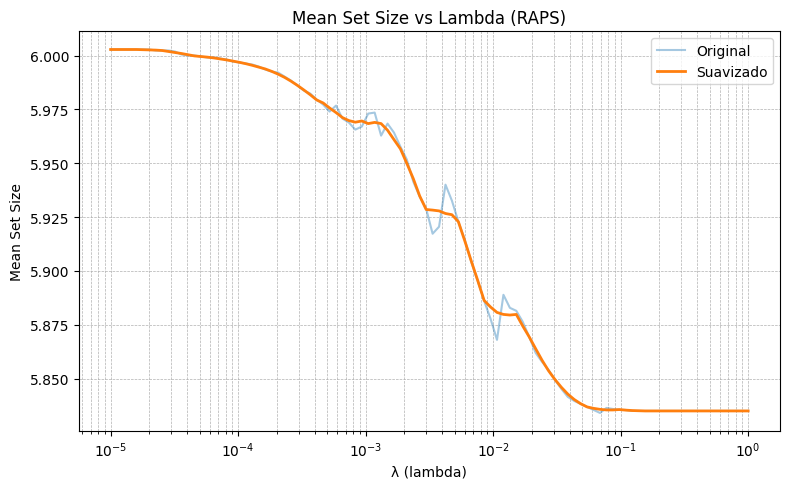

In [ ]:
n = 100

x = np.linspace(-5, 0, n)
lambdas = 10 ** x

results = torch.zeros(n)

for i, lmbda in enumerate(lambdas):
    q_hat = model._calibrate_RAPS(calib_pred_scores, calib_true_labels, lmbda, k_reg, ALPHA, random)
    pred_sets = model._inference_RAPS(test_pred_scores, q_hat, lmbda, k_reg, random)
    results[i] = mean_set_size(pred_sets)
    
def smooth_reflect(y, window_size=5):
    pad_size = window_size // 2
    y_padded = np.pad(y, pad_width=pad_size, mode='reflect')
    kernel = np.ones(window_size) / window_size
    y_smooth = np.convolve(y_padded, kernel, mode='valid')
    return y_smooth

smoothed_results = smooth_reflect(results.numpy(), window_size=5)
print(smoothed_results)

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(lambdas, results.numpy(), label='Original', alpha=0.4)
plt.plot(lambdas, smoothed_results, label='Suavizado', linewidth=2)
plt.xscale('log')
plt.xlabel('λ (lambda)')
plt.ylabel('Mean Set Size')
plt.title('Mean Set Size vs Lambda (RAPS)')
plt.grid(True, which="both", ls="--", lw=0.5)
plt.legend()
plt.tight_layout()
plt.show()

lmbda = lambdas[np.argmin(smoothed_results)]


In [13]:
print(k_reg)

print(lmbda)

7
0.15556761439304723


### CALIBRATION

In [14]:
random=False

In [15]:
# k_reg=5

In [16]:
# Obtiene el número de instancias del conjunto y el número de clases
n, num_classes = calib_pred_scores.shape

# Ordena los scores de mayor a menor y calcula la suma acumulada
sorted_scores, sorted_class_perm_index = torch.sort(calib_pred_scores, dim=1, descending=True)
cum_sorted_scores = torch.cumsum(sorted_scores, dim=1)

# Crea un vector de penalización acumulada para cada posición 
# (a partir de la posición k_reg en adleante añade penalización cte. de lambda_reg)
penalties = torch.zeros((1, num_classes))
penalties[0, k_reg:] += lmbda
cumulative_penalties = torch.cumsum(penalties, dim=1)

# Encuentra, para cada instancia, la posición (0-indexed) de la clase verdadera en el ranking
matches = (sorted_class_perm_index == calib_true_labels.unsqueeze(1))
true_class_rank = matches.int().argmax(dim=1)  # (n,)

# Recolecta los scores y suma acumulada en la posición del índice verdadero
true_score = sorted_scores[torch.arange(n), true_class_rank]
true_cum_score = cum_sorted_scores[torch.arange(n), true_class_rank]

# Obtiene la suma acumulada de las penalizaciones en la posición del índice verdadero
true_cum_penalty = cumulative_penalties[0, true_class_rank]

if random:
    
    # Genera un vector de valores aleatorios entre 0 y 1, uno por instancia 
    U = torch.rand(n, generator=g)
    
    # 
    nonconformity_scores = torch.where(
        true_class_rank >= 1,
        true_cum_score + true_cum_penalty - U * true_score,
        true_score 
    )

else:
    
    #
    nonconformity_scores = true_cum_score + true_cum_penalty


# Calcula el nivel de cuantificación ajustado basado en el tamaño del conjunto de calibración y alpha
q_level = math.ceil((1.0 - ALPHA) * (n + 1.0)) / n

# Calcula el umbral de no conformidad como el percentil q_level de los valores de conformidad 
q_hat = torch.quantile(nonconformity_scores, q_level, interpolation='higher').item()

In [17]:
q_hat

0.9881983399391174

### TEST

In [18]:
# Determina la clase predicha como la clase con mayor puntuación
_, test_pred_labels = torch.max(test_pred_scores, dim=1) 

# Obtiene el número de instancias del conjunto y el número de clases
n, num_classes = test_pred_scores.shape

# Ordena los scores de mayor a menor y calcula la suma acumulada
sorted_scores, sorted_class_perm_index = torch.sort(test_pred_scores, dim=1, descending=True)
cum_sorted_scores = torch.cumsum(sorted_scores, dim=1)

#
penalties = torch.zeros((1, num_classes))
penalties[0, k_reg:] += lmbda
cumulative_penalties = torch.cumsum(penalties, dim=1)

matches = (cum_sorted_scores + cumulative_penalties) <= q_hat
has_match = matches.any(dim=1)
last_class_rank = torch.where(
    has_match,
    matches.int().sum(dim=1)-1,
    torch.ones(n, dtype=torch.uint8)
)

#
if random:
    # Genera un vector de valores aleatorios entre 0 y 1, uno por instancia 
    U = torch.rand(n)
    
    #
    last_score = sorted_scores[torch.arange(n), last_class_rank]
    last_cum_scores = cum_sorted_scores[torch.arange(n), last_class_rank]
    
    #
    last_penalty = penalties[0, last_class_rank]
    last_cum_penalty = cumulative_penalties[0, last_class_rank]
    
    #
    V = (last_cum_scores + last_cum_penalty - q_hat) / (last_score + last_penalty)
    
    #
    last_class_rank = torch.where(
        (U <= V) & (last_class_rank>=1),
        last_class_rank-1,
        last_class_rank
    )

#
idx = torch.arange(num_classes)
inclusion_mask = idx <= last_class_rank.unsqueeze(1)

# 
test_pred_sets = torch.zeros_like(test_pred_scores, dtype=torch.uint8)
test_pred_sets.scatter_(1, sorted_class_perm_index, inclusion_mask.to(torch.uint8))

tensor([[0, 0, 0,  ..., 1, 1, 0],
        [0, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.uint8)

In [19]:
# Calcula y muestra la exactitud
accry = (test_pred_labels == test_true_labels).sum() / test_true_labels.size(0)
print(f"Accuracy: {accry*100:>4.2f} %")

# Calcula y muestra la cobertura empírica 
ec = empirical_coverage_classification(test_pred_sets, test_true_labels)
print(f"Cobertura empírica: {ec*100:>4.2f} %")

# Calcula y muestra el tamaño medio del conjunto
mss = mean_set_size(test_pred_sets)
print(f"Tamaño medio de conjunto: {mss:>4.2f}")

Accuracy: 25.79 %
Cobertura empírica: 93.87 %
Tamaño medio de conjunto: 5.84


In [20]:
#
num_labels, num_instances, coverage = each_size_coverage(test_pred_sets, test_true_labels)
for l, i, c in zip(num_labels, num_instances, coverage):
    print(f"Número de etiquetas: {l}, Instancias: {i}, Cobertura: {(c*100):.2f}%")

Número de etiquetas: 1, Instancias: 2, Cobertura: 50.00%
Número de etiquetas: 2, Instancias: 104, Cobertura: 92.31%
Número de etiquetas: 3, Instancias: 194, Cobertura: 91.75%
Número de etiquetas: 4, Instancias: 161, Cobertura: 92.55%
Número de etiquetas: 5, Instancias: 114, Cobertura: 92.11%
Número de etiquetas: 6, Instancias: 488, Cobertura: 93.24%
Número de etiquetas: 7, Instancias: 1089, Cobertura: 95.13%
